In [1]:
import os
import pandas as pd
import torch
import numpy as np
import pickle

def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K(object):
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K

def compare(a,b):
    tmp1 = int(a[:-4])
    tmp2 = int(b[:-4])
    return tmp1 - tmp2

def get_partition(df, num_of_steps, num_of_classes, end_time = None):
    if end_time == None:
        end_time = df['time'][len(df['time'])-1]
    res = torch.zeros(num_of_steps, num_of_classes + 1)
    dt = end_time/num_of_steps
    res[:,0] = end_time/num_of_steps
    for i in range(len(df['time'])):
        k = int(df['time'][i]/dt)
        if k == num_of_steps:
            k-=1
        res[k,int(df['event'][i])+1] += 1
    return res

def get_dataset(path_to_files, n_classes, n_steps):
    files = os.listdir(path_to_files)
    target = None
    if 'clusters.csv' in files:
        files.remove('clusters.csv')
        target = torch.Tensor(pd.read_csv(path_to_files+'/clusters.csv')['cluster_id'])
    #print(target)
    files = sorted(files, key = cmp_to_key(compare))
    data = torch.zeros(len(files), n_steps, n_classes + 1)
    for i, f in enumerate(files):
        df = pd.read_csv(path_to_files+'/'+f)
        data[i,:,:] = get_partition(df, n_steps, n_classes)
    return data, target

path_to_files = 'data/simulated_Hawkes/K2_C5'
N_STEPS = 128
N_CLUSTERS = 2
EPS = 0.8
n_runs = 5

data, target = get_dataset(path_to_files, 5, N_STEPS)

#with open('utils/data.pkl', 'rb') as f:
#    data = pickle.load(f)
#    
#with open('utils/clusters.pkl', 'rb') as f:
#    target = pickle.load(f)
indices = np.random.permutation(data.shape[0])
data_train, target_train = data[indices[:9*data.shape[0]//10]],\
                           target[indices[:9*data.shape[0]//10]]
data_test, target_test = data[indices[9*data.shape[0]//10:]],\
                           target[indices[9*data.shape[0]//10:]]

import torch
from models.models import LSTM_cluster_point_processes
from utils.trainers import Trainer_clusterwise

device = 'cuda:1'

all_purs = []
all_purs_val = []
i = 0
#while i<n_runs:
test_param = [1.0001,1.0002,1.0005,1.001,1.002,1.003,1.005,1.01,1.02,1.05,1.1]
#success = []
for i in test_param:
    #print('Run {}/{}'.format(i+1, n_runs))
    print('alpha =', i)
    model = LSTM_cluster_point_processes(6,128, 3, 5, 2, N_STEPS, dropout = 0.3).to(device)
    #model.load_state_dict(torch.load('reserv.pt'))
    optimizer = torch.optim.Adam(model.parameters(), lr =0.1, weight_decay = 1e-5)
    trainer = Trainer_clusterwise(model, optimizer, device, data, data_test,\
                              target, target_test, 2, alpha = i, beta = 0.001,\
                              epsilon = 1e-8, l = 10, eps = 0.2/N_CLUSTERS,\
                              max_epochs = 25, max_m_step_epochs = 30,\
                              lr_update_tol = 15, lr_update_param = 0.9,\
                             batch_size = 200)

    losses, purs, purs_val, cluster_part = trainer.train()
    if cluster_part == None:
        continue
    if cluster_part < EPS/N_CLUSTERS:
        print("Degenerate solution")
        #continue
    if losses:
        all_purs+=purs
        all_purs_val += purs_val
        i+=1


alpha = 1.0001
Beginning e-step
tensor(800., device='cuda:1')
Cluster partition
Cluster 0 :  0.91375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.08625  with pi =  tensor(0.5000, device='cuda:1')
Purity for random model: 0.50875
Beginning m-step
Entropy value: tensor(-1.5587e-07, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 60495.717447916664
Loss on sub_epoch 11/30: 34223.600260416664
Loss on sub_epoch 21/30: 34134.83984375
Cluster partition
Cluster 0 :  0.43  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.57  with pi =  tensor(0.5000, device='cuda:1')
On epoch 1/25 average loss = 36062.79765625, purity = 0.7949999999999999
Validation loss = 13414.107421875, purity = 0.775
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34090.479166666664
Updating lr
Loss on sub_epoch 11/30: 34134.065104166664
Loss on sub_epoch 21/30: 34087.744791666664
Cluster partition
Cluster 0 :  0.47375  with pi =  tensor(0

Entropy value: tensor(-1379.8882, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.1646, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1464, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32424.833333333332
Entropy value: tensor(-1385.8738, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1726, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.1824, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6893, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3905, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBa

Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3901, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6891, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3452, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.7089, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9291, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32897.141276041664
Entropy value: tensor(-1386.1936, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1871, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.4574, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.4027, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6759, device='cuda:1', grad_fn=<MulBa

Entropy value: tensor(-1385.8950, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7686, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.5171, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 15/25 average loss = 32886.138020833336, purity = 0.99875
Validation loss = 12780.3359375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1386.1810, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32896.83203125
Entropy value: tensor(-1386.2201, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4727, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.3557, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.7122, device='cuda:1', grad_fn=<MulBackwa

Entropy value: tensor(-1385.3961, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6503, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.9514, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8894, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32847.35546875
Entropy value: tensor(-1366.6299, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1929, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1846, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1366.5314, device='cuda:1', grad_f

Entropy value: tensor(-1385.3936, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8978, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1754, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 22/25 average loss = 32910.60555555556, purity = 0.99875
Validation loss = 12775.51953125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1374.1389, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32871.768880208336
Entropy value: tensor(-1360.5841, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2941, device='cuda:1', grad_fn=<MulBa

Updating lr
Loss on sub_epoch 21/30: 34094.56640625
Cluster partition
Cluster 0 :  0.4975  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5025  with pi =  tensor(0.5000, device='cuda:1')
On epoch 2/25 average loss = 34048.503255208336, purity = 0.9425000000000001
Validation loss = 13331.09375, purity = 0.9000000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33856.266927083336
Loss on sub_epoch 11/30: 33209.126302083336
Updating lr
Loss on sub_epoch 21/30: 33385.3984375
Cluster partition
Cluster 0 :  0.4975  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5025  with pi =  tensor(0.5000, device='cuda:1')
On epoch 3/25 average loss = 33365.04123263889, purity = 0.9975
Validation loss = 12927.740234375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32773.966145833336
Entropy value: tensor(-1385.8947, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 

Entropy value: tensor(-1385.8906, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2803, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.7883, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6852, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33001.564453125
Entropy value: tensor(-1385.8922, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1830, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2822, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3910, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6558, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, de

Entropy value: tensor(-1383.7937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.2297, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7640, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32962.23046875
Entropy value: tensor(-1386.2933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7827, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1371.8597, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2177, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8947, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7722, device='cuda:1', grad_fn=<MulBackwa

Entropy value: tensor(-1386.2007, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2939, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 16/25 average loss = 32877.1966796875, purity = 0.99875
Validation loss = 12800.755859375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32481.951822916668
Entropy value: tensor(-1381.4734, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9060, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8938, device='cuda:1', gr

Entropy value: tensor(-1385.3945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.7308, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1841, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.9336, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3857, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33047.768229166664
Entropy value: tensor(-1383.7937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.5769, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33032.500651041664
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor

Entropy value: tensor(-1385.3546, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.7026, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.4000, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1371.8386, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6912, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 23/25 average loss = 32850.36056857639, purity = 0.99875
Validation loss = 12795.6982421875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1385.3940, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32964.639322916664
Entropy value: tensor(-1386.1873, device='cuda:1', grad_fn=<Mul

Entropy value: tensor(-1378.2607, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1953, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33133.196614583336
Entropy value: tensor(-1376.2776, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2778, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 7/25 average loss = 32730.375303819445, purity = 0.99875
Validation loss = 12841.234375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Updating lr
Loss on sub_epoch 1/30: 32658.350260416668
Entropy value: tensor(-1386.1997, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub

Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32639.41796875
Entropy value: tensor(-1385.3674, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32589.643229166668
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9218, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6919, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 14/25 average loss = 32808.61200086806, purity = 0.99875
Validation loss = 12834.8388671875, purity

Loss on sub_epoch 21/30: 33273.180989583336
Entropy value: tensor(-1381.5342, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8877, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 20/25 average loss = 32840.09598524305, purity = 0.99875
Validation loss = 12840.275390625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32664.350260416668
Entropy value: tensor(-1381.3905, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6882, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2872, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 11/30: 32600.278645833332
Entropy value: tensor(-1383.7933, device='cud

Validation loss = 13078.4873046875, purity = 0.9875
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33120.661458333336
Loss on sub_epoch 11/30: 32914.261067708336
Updating lr
Loss on sub_epoch 21/30: 32874.701171875
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 4/25 average loss = 32916.31859809028, purity = 0.99875
Validation loss = 12900.142578125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32819.755208333336
Loss on sub_epoch 11/30: 32856.417317708336
Updating lr
Loss on sub_epoch 21/30: 32978.618489583336
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 5/25 average loss = 32854.50373263889, purity = 0.99875
Validation loss = 12910.8212890625, purity = 1.0
Beginning e-st

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32785.100911458336
Updating lr
Loss on sub_epoch 11/30: 32790.659505208336
Loss on sub_epoch 21/30: 32819.514322916664
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 22/25 average loss = 32788.199609375, purity = 0.99875
Validation loss = 12895.818359375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32783.336588541664
Loss on sub_epoch 11/30: 32751.3984375
Updating lr
Loss on sub_epoch 21/30: 32813.857421875
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 23/25 average loss = 32769.7076171875, purity = 0.99875
Validation loss = 12895.8837890625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 3

Loss on sub_epoch 21/30: 33147.259114583336
Updating lr
Cluster partition
Cluster 0 :  0.50375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 14/25 average loss = 33105.30481770833, purity = 0.9962500000000001
Validation loss = 13041.375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33175.854166666664
Loss on sub_epoch 11/30: 33054.014322916664
Loss on sub_epoch 21/30: 33081.598958333336
Cluster partition
Cluster 0 :  0.5025  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4975  with pi =  tensor(0.5000, device='cuda:1')
On epoch 15/25 average loss = 33099.75900607639, purity = 0.9975
Validation loss = 13038.3173828125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Updating lr
Loss on sub_epoch 1/30: 33160.973958333336
Loss on sub_epoch 11/30: 33126.029947916664
Loss on sub_epoch 21/30: 33092.302083333336
Cluster partiti

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34571.575520833336
Updating lr
Loss on sub_epoch 11/30: 34332.587239583336
Loss on sub_epoch 21/30: 34291.946614583336
Cluster partition
Cluster 0 :  0.5175  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4825  with pi =  tensor(0.5000, device='cuda:1')
On epoch 7/25 average loss = 34345.151866319444, purity = 0.6699999999999999
Validation loss = 13522.7099609375, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34212.927083333336
Updating lr
Loss on sub_epoch 11/30: 34221.955729166664
Loss on sub_epoch 21/30: 34102.92578125
Cluster partition
Cluster 0 :  0.5575  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4425  with pi =  tensor(0.5000, device='cuda:1')
On epoch 8/25 average loss = 34180.03159722222, purity = 0.685
Validation loss = 13513.5224609375, purity = 0.625
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on 

Cluster partition
Cluster 0 :  0.50375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 24/25 average loss = 33390.144574652775, purity = 0.9962500000000001
Validation loss = 13158.953125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33327.272135416664
Updating lr
Loss on sub_epoch 11/30: 33307.680989583336
Loss on sub_epoch 21/30: 33477.61328125
Cluster partition
Cluster 0 :  0.50375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 25/25 average loss = 33381.06905381945, purity = 0.9962500000000001
Validation loss = 13150.6005859375, purity = 1.0
alpha = 1.005
Beginning e-step
tensor(800., device='cuda:1')
Cluster partition
Cluster 0 :  0.1225  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.8775  with pi =  tensor(0.5000, device='cuda:1')
Purity for random model: 0.52
Beginning m-ste

Validation loss = 13383.3623046875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33918.087239583336
Loss on sub_epoch 11/30: 33966.248697916664
Updating lr
Loss on sub_epoch 21/30: 33976.274739583336
Cluster partition
Cluster 0 :  0.495  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.505  with pi =  tensor(0.5000, device='cuda:1')
On epoch 17/25 average loss = 33934.22421875, purity = 0.995
Validation loss = 13381.6083984375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34011.3515625
Updating lr
Loss on sub_epoch 11/30: 33975.654947916664
Loss on sub_epoch 21/30: 33919.799479166664
Cluster partition
Cluster 0 :  0.495  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.505  with pi =  tensor(0.5000, device='cuda:1')
On epoch 18/25 average loss = 33921.03836805555, purity = 0.995
Validation loss = 13371.7109375, purity = 1.0
Beginning e-step
tensor(800., devi

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 35296.795572916664
Loss on sub_epoch 11/30: 35281.6875
Loss on sub_epoch 21/30: 35206.197916666664
Updating lr
Cluster partition
Cluster 0 :  0.51  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49  with pi =  tensor(0.5000, device='cuda:1')
On epoch 9/25 average loss = 35222.39249131944, purity = 0.99
Validation loss = 13908.5224609375, purity = 0.9875
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 35192.059895833336
Loss on sub_epoch 11/30: 35174.514322916664
Loss on sub_epoch 21/30: 35267.446614583336
Updating lr
Cluster partition
Cluster 0 :  0.50625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 10/25 average loss = 35147.65234375, purity = 0.99375
Validation loss = 13886.5244140625, purity = 0.9875
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 3505

Loss on sub_epoch 11/30: 38139.641927083336
Loss on sub_epoch 21/30: 37868.634114583336
Cluster partition
Cluster 0 :  0.5025  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4975  with pi =  tensor(0.5000, device='cuda:1')
On epoch 1/25 average loss = 40744.27365451389, purity = 0.6300000000000001
Validation loss = 15026.3330078125, purity = 0.675
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 37909.858072916664
Updating lr
Loss on sub_epoch 11/30: 37788.3046875
Loss on sub_epoch 21/30: 37869.6484375
Cluster partition
Cluster 0 :  0.4625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 2/25 average loss = 37868.43645833333, purity = 0.8575
Validation loss = 15017.4111328125, purity = 0.8500000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 37873.72265625
Updating lr
Loss on sub_epoch 11/30: 37655.178385416664
Loss on s

Entropy value: tensor(-962.6108, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-753.7122, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-829.0295, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-879.9344, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-790.7282, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-757.5906, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-819.9489, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 38054.247395833336
Entropy value: tensor(-708.0808, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-707.9183, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-806.2039, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-878.1151, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-700.8882, device='cuda:1', grad_fn=<MulBackward0>) Fa

Entropy value: tensor(-314.8478, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-243.2332, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-344.3376, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-330.9496, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-378.1992, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-303.9861, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-271.0734, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-306.2103, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-362.9637, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-267.4498, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-222.1167, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-385.1650, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-299.2068, device=

Entropy value: tensor(-319.0095, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-150.0439, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.8878, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-211.9579, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-237.0285, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-157.4669, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-217.6736, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-185.4234, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-123.5754, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-224.5802, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.2447, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-135.0721, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-199.2230, device=

Entropy value: tensor(-112.0069, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7652, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7649, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-111.5889, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0775, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-189.3092, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-111.8868, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0361, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0782, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0726, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-190.6541, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7369, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7650, device=

Entropy value: tensor(-303.4249, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-111.8713, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-129.8857, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0030, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-302.1605, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9582, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.2363, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-287.6998, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0041, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 35826.2734375
Entropy value: tensor(-111.8938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0032, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-148.5693, device='cuda:1', grad_fn=<MulBackward0>) Fails
En

Entropy value: tensor(-196.0729, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-122.5930, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 35778.606770833336
Entropy value: tensor(-191.6154, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7651, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-162.4948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7608, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9591, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0032, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0783, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-85.0364, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-233.4413, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0758, device='cuda:1', grad_fn=<MulBackward0>) Fail

Entropy value: tensor(-155.7651, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-233.8098, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-77.3867, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-154.6965, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-242.5953, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-111.9141, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0012, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-204.7788, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-107.8178, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-154.6179, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0032, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-209.3802,

Entropy value: tensor(-112.0030, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-151.4899, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-40.0375, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-108.3276, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0709, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0355, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7651, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9590, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-10.9431, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-302.4602, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7527, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-195.8717, device='cud

Entropy value: tensor(-196.0735, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-165.2181, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-233.8148, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-154.9886, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-74.8603, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-120.9804, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-194.2711, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0002, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.015  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.985  with pi =  tensor(0.5000, device='cuda:1')
On epoch 18/25 average loss = 35855.48758680555, purity = 0.5025000000000001
Validation loss = 14130.080078125, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-16

Entropy value: tensor(-189.9848, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.015  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.985  with pi =  tensor(0.5000, device='cuda:1')
On epoch 19/25 average loss = 35848.653428819445, purity = 0.5025000000000001
Validation loss = 14135.7373046875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-158.6734, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-195.9593, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0032, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 35796.944010416664
Entropy value: tensor(-155.7632, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0035, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-157.9250, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-116.1628, device='cuda:1', grad_fn=<

Entropy value: tensor(-112.0032, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 35817.85546875
Entropy value: tensor(-199.9280, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0020, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-154.2337, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0034, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-115.6404, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-227.2953, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0777, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-229.1411, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-69.0720, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-195.9649, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-69.7631, device='cuda:1', grad_fn=<MulBackward0>) Fails
Ent

Entropy value: tensor(-195.8495, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0777, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-110.0931, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-197.6922, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-233.8114, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-110.8545, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-195.3050, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-157.9406, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0726, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0003, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.6725, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-152.9634, device='

Entropy value: tensor(-111.9927, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-194.2074, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-109.7973, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-233.7084, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-69.6986, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7611, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-195.0453, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-161.8554, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7164, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0032, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-201.4012, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-160.6598, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-109.9901, device='

Entropy value: tensor(-152.5645, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0028, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-59.1473, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-200.6248, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0697, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-301.7412, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-10.3548, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-195.9754, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-153.9281, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7615, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 35916.119791666664
Entropy value: tensor(-62.9583, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-197.2714, device='cuda:1', grad_fn=<MulBackward0>) Fails

Entropy value: tensor(-266.7740, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7340, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 35779.06640625
Entropy value: tensor(-50.4209, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-195.0145, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-196.0677, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-113.0819, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7358, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0031, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.6083, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-111.9968, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-156.9349, device='cuda:1', grad_fn=<MulBackward0>) Fails
En

Updating lr
Loss on sub_epoch 11/30: 39716.42578125
Loss on sub_epoch 21/30: 39832.588541666664
Cluster partition
Cluster 0 :  0.68  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.32  with pi =  tensor(0.5000, device='cuda:1')
On epoch 7/25 average loss = 39846.675217013886, purity = 0.77
Validation loss = 15964.0908203125, purity = 0.7875000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 40038.954427083336
Loss on sub_epoch 11/30: 40021.434895833336
Updating lr
Loss on sub_epoch 21/30: 39954.451822916664
Cluster partition
Cluster 0 :  0.7425  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.2575  with pi =  tensor(0.5000, device='cuda:1')
On epoch 8/25 average loss = 39866.032942708334, purity = 0.725
Validation loss = 15957.1533203125, purity = 0.7250000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 39622.666666666664
Loss on sub_epoch 11/30: 39924.194010416664
Upd

Entropy value: tensor(-327.0493, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-478.6127, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-543.9637, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-450.2576, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-494.5389, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-448.5584, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 39653.625
Entropy value: tensor(-338.1308, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-454.4323, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-427.7510, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-471.1683, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-392.6965, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-513.5217, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entro

Entropy value: tensor(-72.1380, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-90.4485, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9685, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1.5241, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-110.9126, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9778, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-63.6665, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9600, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-63.1313, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0404, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.8167, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-66.4631, device='cuda:1', grad_

Entropy value: tensor(-5.5274e-05, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0002, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0031, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2.0376e-06, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0011, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-155.7721, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0014, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0032, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-3.6713e-05, device='cud

Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0002, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9622, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9589, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0002, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0033, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9580, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0007, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0010, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9689, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.99625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.00375  with pi =  tensor(0.5000, dev

Entropy value: tensor(-0.0001, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0061, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0031, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.99625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.00375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 23/25 average loss = 32617.38708767361, purity = 0.50125
Validation loss = 12971.6845703125, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-8.1962e-06, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9578, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32628.302083333332
Entropy value: tensor(-62.9582, device='cuda:1', grad_fn=<MulBackward0>)

tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-112.0043, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9585, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-3.6330e-07, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32616.997395833332
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-4.3057e-08, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0001, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-112.0102, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0002, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-0.0002, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-62.9581, devi

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 37506.115885416664
Updating lr
Loss on sub_epoch 11/30: 37688.608072916664
Loss on sub_epoch 21/30: 37641.540364583336
Cluster partition
Cluster 0 :  0.97375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.02625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 2/25 average loss = 37527.94470486111, purity = 0.50125
Validation loss = 15178.0048828125, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 37341.1171875
Updating lr
Loss on sub_epoch 11/30: 37472.638020833336
Loss on sub_epoch 21/30: 37444.55078125
Cluster partition
Cluster 0 :  0.0375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.9625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 3/25 average loss = 37501.918012152775, purity = 0.51
Validation loss = 15220.388671875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30:

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 36968.6328125
Loss on sub_epoch 11/30: 37769.365885416664
Updating lr
Loss on sub_epoch 21/30: 37508.569010416664
Cluster partition
Cluster 0 :  0.04375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.95625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 20/25 average loss = 37450.37816840278, purity = 0.50875
Validation loss = 15167.1669921875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 37286.731770833336
Loss on sub_epoch 11/30: 37343.760416666664
Updating lr
Loss on sub_epoch 21/30: 37434.3203125
Cluster partition
Cluster 0 :  0.045  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.955  with pi =  tensor(0.5000, device='cuda:1')
On epoch 21/25 average loss = 37460.77638888889, purity = 0.51
Validation loss = 15167.87890625, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 37

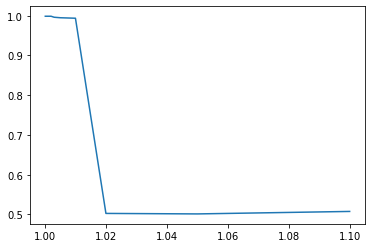

In [7]:
import numpy as np
import matplotlib.pyplot as plt
a = np.array(all_purs)
x = np.array(test_param)
plt.plot(x,a[24::25,1])

In [9]:
a[24::25]

array([[3.30658333e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30296335e+04, 9.98750000e-01, 4.98750000e-01],
       [3.27106999e+04, 9.98750000e-01, 4.98750000e-01],
       [3.27931816e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30692435e+04, 9.98750000e-01, 4.98750000e-01],
       [3.34578138e+04, 9.96250000e-01, 4.96250000e-01],
       [3.38280286e+04, 9.95000000e-01, 4.95000000e-01],
       [3.50182122e+04, 9.93750000e-01, 4.93750000e-01],
       [3.58045312e+04, 5.02500000e-01, 1.50000000e-02],
       [3.25387214e+04, 5.01250000e-01, 3.75000000e-03],
       [3.75018802e+04, 5.07500000e-01, 4.50000000e-02]])

In [10]:
a

array([[3.40384740e+04, 7.95000000e-01, 4.30000000e-01],
       [3.40945990e+04, 8.61250000e-01, 4.73750000e-01],
       [3.39643060e+04, 9.78750000e-01, 4.96250000e-01],
       [3.26543529e+04, 9.98750000e-01, 4.98750000e-01],
       [3.25316016e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30699141e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29791934e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30791081e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29640280e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29984557e+04, 9.98750000e-01, 4.98750000e-01],
       [3.28976439e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29574095e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29491413e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29087702e+04, 9.98750000e-01, 4.98750000e-01],
       [3.28866979e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30056211e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29574004e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30177194e+04, 9.98750

In [12]:
all_purs = []
all_purs_val = []
i = 0
#while i<n_runs:
test_param = [0.0,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1]
#success = []
for i in test_param:
    #print('Run {}/{}'.format(i+1, n_runs))
    print('beta =', i)
    model = LSTM_cluster_point_processes(6,128, 3, 5, 2, N_STEPS, dropout = 0.3).to(device)
    #model.load_state_dict(torch.load('reserv.pt'))
    optimizer = torch.optim.Adam(model.parameters(), lr =0.1, weight_decay = 1e-5)
    trainer = Trainer_clusterwise(model, optimizer, device, data, data_test,\
                              target, target_test, 2, alpha = 1.0001, beta = i,\
                              epsilon = 1e-8, l = 10, eps = 0.2/N_CLUSTERS,\
                              max_epochs = 25, max_m_step_epochs = 30,\
                              lr_update_tol = 15, lr_update_param = 0.9,\
                             batch_size = 200)

    losses, purs, purs_val, cluster_part = trainer.train()
    if cluster_part == None:
        continue
    if cluster_part < EPS/N_CLUSTERS:
        print("Degenerate solution")
        #continue
    if losses:
        all_purs+=purs
        all_purs_val += purs_val
        i+=1


beta = 0.0
Beginning e-step
tensor(800., device='cuda:1')
Cluster partition
Cluster 0 :  0.84375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.15625  with pi =  tensor(0.5000, device='cuda:1')
Purity for random model: 0.50625
Beginning m-step
Loss on sub_epoch 1/30: 64852.1484375
Loss on sub_epoch 11/30: 34375.46484375
Loss on sub_epoch 21/30: 33994.983072916664
Cluster partition
Cluster 0 :  0.45625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.54375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 1/25 average loss = 36242.07309027778, purity = 0.60875
Validation loss = 13391.9873046875, purity = 0.675
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33923.799479166664
Updating lr
Loss on sub_epoch 11/30: 33996.43359375
Loss on sub_epoch 21/30: 34002.381510416664
Cluster partition
Cluster 0 :  0.4675  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5325  with pi =  tensor(0.5000, device='cuda:1')
On epoch 

Entropy value: tensor(-1376.2762, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6895, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3934, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32327.463541666668
Entropy value: tensor(-1382.6959, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6973, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1842, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1973, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32849.568359375
Entropy value: tensor(-1386.1946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy valu

Entropy value: tensor(-1386.1920, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1932, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3971, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 13/25 average loss = 32703.545920138888, purity = 0.99875
Validation loss = 12739.81640625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1376.3391, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32782.374348958336
Entropy value: tensor(-1386.1963, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1960, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9088, device='cuda:1', grad_fn=<MulB

Entropy value: tensor(-1385.8832, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6350, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.9402, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3949, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7872, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7925, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32940.592447916664
Entropy value: tensor(-1386.2074, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8978, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1379.9358, device='cuda:1', gr

Entropy value: tensor(-1385.8905, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1385.3801, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8954, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 20/25 average loss = 32687.408680555556, purity = 0.99875
Validation loss = 12716.521484375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1382.6829, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32776.592447916664
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.2341, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4193, device='cuda:1', 

Entropy value: tensor(-1383.7949, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9133, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 21/30: 32815.079427083336
Entropy value: tensor(-1383.8394, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2717, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1836, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.9717, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1371.7654, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, dev

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33161.006510416664
Loss on sub_epoch 11/30: 33287.365885416664
Updating lr
Loss on sub_epoch 21/30: 33261.432291666664
Cluster partition
Cluster 0 :  0.475  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.525  with pi =  tensor(0.5000, device='cuda:1')
On epoch 12/25 average loss = 33316.13350694445, purity = 0.7275
Validation loss = 13169.533203125, purity = 0.6875
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33367.540364583336
Loss on sub_epoch 11/30: 33247.223958333336
Updating lr
Loss on sub_epoch 21/30: 33367.651041666664
Cluster partition
Cluster 0 :  0.48375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.51625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 13/25 average loss = 33308.864583333336, purity = 0.72875
Validation loss = 13173.1923828125, purity = 0.6875
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_

Loss on sub_epoch 1/30: 34103.161458333336
Updating lr
Loss on sub_epoch 11/30: 33979.415364583336
Loss on sub_epoch 21/30: 33924.12890625
Cluster partition
Cluster 0 :  0.4575  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5425  with pi =  tensor(0.5000, device='cuda:1')
On epoch 4/25 average loss = 33985.313585069445, purity = 0.5975
Validation loss = 13376.29296875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34000.4375
Updating lr
Loss on sub_epoch 11/30: 33960.5546875
Loss on sub_epoch 21/30: 33893.903645833336
Cluster partition
Cluster 0 :  0.45625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.54375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 5/25 average loss = 33934.50134548611, purity = 0.61625
Validation loss = 13276.603515625, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33763.6640625
Updating lr
Loss on sub_epoch 11/30: 335

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33176.373697916664
Loss on sub_epoch 11/30: 33247.592447916664
Loss on sub_epoch 21/30: 33207.259114583336
Updating lr
Cluster partition
Cluster 0 :  0.50375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 22/25 average loss = 33270.31375868055, purity = 0.74875
Validation loss = 13168.8134765625, purity = 0.7250000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33318.787760416664
Loss on sub_epoch 11/30: 33241.954427083336
Loss on sub_epoch 21/30: 33320.6953125
Updating lr
Cluster partition
Cluster 0 :  0.515  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.485  with pi =  tensor(0.5000, device='cuda:1')
On epoch 23/25 average loss = 33274.524305555555, purity = 0.7525000000000001
Validation loss = 13177.9189453125, purity = 0.7375
Beginning e-step
tensor(800., device='cuda:1')
Beginning

Loss on sub_epoch 11/30: 33007.793619791664
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8950, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4211, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.8159, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2819, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8917, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 21/30: 32919.438151041664
Entropy value: tensor(-1382.7411, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1990, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6985, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy v

Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1371.8596, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6199, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 13/25 average loss = 32833.41271701389, purity = 0.99875
Validation loss = 12765.9189453125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32890.958984375
Entropy value: tensor(-1376.2781, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7258, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1363.3783, device='cuda:1', grad_fn=<MulBac

Entropy value: tensor(-1379.8877, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2778, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2778, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1560, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8950, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 21/30: 32989.483072916664
Entropy value: tensor(-1369.5776, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.7046, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1697, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.1925, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6909, device='cuda:1', gr

Validation loss = 12758.3828125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1383.7644, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32906.701822916664
Entropy value: tensor(-1382.6935, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.9307, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8876, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.3188, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.9341, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.9031, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33012.633463541664
Entropy value: tensor(-1385.9141, device='cuda:1', grad_fn=<MulBackward0>)

Entropy value: tensor(-1374.1698, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8899, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4021, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1951, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1694, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 24/25 average loss = 32805.112803819444, purity = 0.99875
Validation loss = 12752.9951171875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32586.801432291668
Entropy value: tensor(-1374.1697, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8872, device='cuda:1', grad_fn=<Mu

tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1386.2103, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32937.807942708336
Entropy value: tensor(-1385.8942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2815, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.7603, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9336, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8887, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8950, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6978, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32965.502604166664
Entropy value: tensor(-1385.8142, device='cuda:1', grad_

Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8872, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1941, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 13/25 average loss = 32797.1896484375, purity = 0.99875
Validation loss = 12776.3583984375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1384.7129, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32940.688802083336
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3921, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulB

Entropy value: tensor(-1378.1833, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32949.84765625
Entropy value: tensor(-1384.6899, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1707, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7598, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9100, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.7029, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9076, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 17/25 average loss = 32804.14090711805, purity = 0.99875
Validation loss =

KeyboardInterrupt: 

In [15]:
all_purs = []
all_purs_val = []
#while i<n_runs:
test_param = [0.5,0.6,0.7,0.8,0.9,0.95]
#success = []
for i in test_param:
    #print('Run {}/{}'.format(i+1, n_runs))
    print('lr_param =', i)
    for j in range(5):
        model = LSTM_cluster_point_processes(6,128, 3, 5, 2, N_STEPS, dropout = 0.3).to(device)
    #model.load_state_dict(torch.load('reserv.pt'))
        optimizer = torch.optim.Adam(model.parameters(), lr =0.1, weight_decay = 1e-5)
        trainer = Trainer_clusterwise(model, optimizer, device, data, data_test,\
                              target, target_test, 2, alpha = 1.0001, beta = 0.001,\
                              epsilon = 1e-8, l = 10, eps = 0.2/N_CLUSTERS,\
                              max_epochs = 25, max_m_step_epochs = 30,\
                              lr_update_tol = 15, lr_update_param = i,\
                             batch_size = 200)

        losses, purs, purs_val, cluster_part = trainer.train()
        if cluster_part == None:
            continue
        if cluster_part < EPS/N_CLUSTERS:
            print("Degenerate solution")
            #continue
        if losses:
            all_purs+=purs
            all_purs_val += purs_val

lr_param = 0.5
Beginning e-step
tensor(800., device='cuda:1')
Cluster partition
Cluster 0 :  0.1  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.9  with pi =  tensor(0.5000, device='cuda:1')
Purity for random model: 0.5625
Beginning m-step
Loss on sub_epoch 1/30: 70699.50390625
Loss on sub_epoch 11/30: 34516.427083333336
Loss on sub_epoch 21/30: 34090.809895833336
Cluster partition
Cluster 0 :  0.525  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.475  with pi =  tensor(0.5000, device='cuda:1')
On epoch 1/25 average loss = 36911.88454861111, purity = 0.6799999999999999
Validation loss = 13426.7099609375, purity = 0.7125000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34115.067708333336
Updating lr
Loss on sub_epoch 11/30: 34011.135416666664
Loss on sub_epoch 21/30: 34079.716145833336
Cluster partition
Cluster 0 :  0.56625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.43375  with pi =  tensor(0.5000, 

tensor(800., device='cuda:1')
Beginning m-step
Updating lr
Loss on sub_epoch 1/30: 33616.677083333336
Loss on sub_epoch 11/30: 33553.06640625
Loss on sub_epoch 21/30: 33544.471354166664
Cluster partition
Cluster 0 :  0.49  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.51  with pi =  tensor(0.5000, device='cuda:1')
On epoch 18/25 average loss = 33538.818619791666, purity = 0.5800000000000001
Validation loss = 13219.7041015625, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33499.921875
Updating lr
Loss on sub_epoch 11/30: 33571.350260416664
Loss on sub_epoch 21/30: 33525.28125
Cluster partition
Cluster 0 :  0.49  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.51  with pi =  tensor(0.5000, device='cuda:1')
On epoch 19/25 average loss = 33544.81948784722, purity = 0.5800000000000001
Validation loss = 13219.6943359375, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_e

Loss on sub_epoch 1/30: 33548.657552083336
Loss on sub_epoch 11/30: 33486.98046875
Updating lr
Loss on sub_epoch 21/30: 33523.110677083336
Cluster partition
Cluster 0 :  0.49125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 10/25 average loss = 33518.251171875, purity = 0.6312500000000001
Validation loss = 13208.4130859375, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33594.895833333336
Updating lr
Loss on sub_epoch 11/30: 33498.255208333336
Loss on sub_epoch 21/30: 33565.151041666664
Cluster partition
Cluster 0 :  0.4925  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5075  with pi =  tensor(0.5000, device='cuda:1')
On epoch 11/25 average loss = 33523.438975694444, purity = 0.6325000000000001
Validation loss = 13209.322265625, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33544.94140625
L

Loss on sub_epoch 1/30: 34047.717447916664
Updating lr
Loss on sub_epoch 11/30: 34066.733072916664
Loss on sub_epoch 21/30: 33976.001302083336
Cluster partition
Cluster 0 :  0.21875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.78125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 2/25 average loss = 34043.89327256945, purity = 0.50375
Validation loss = 13395.6591796875, purity = 0.625
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33957.657552083336
Loss on sub_epoch 11/30: 34002.989583333336
Updating lr
Loss on sub_epoch 21/30: 34055.403645833336
Cluster partition
Cluster 0 :  0.43375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.56625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 3/25 average loss = 34026.604079861114, purity = 0.6012500000000001
Validation loss = 13386.1669921875, purity = 0.6625
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34023.252604166664
Lo

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33520.631510416664
Loss on sub_epoch 11/30: 33419.989583333336
Loss on sub_epoch 21/30: 33545.920572916664
Updating lr
Cluster partition
Cluster 0 :  0.49125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 20/25 average loss = 33530.84661458333, purity = 0.64375
Validation loss = 13218.1455078125, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33485.325520833336
Loss on sub_epoch 11/30: 33510.868489583336
Loss on sub_epoch 21/30: 33572.130208333336
Cluster partition
Cluster 0 :  0.49125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 21/25 average loss = 33535.37730034722, purity = 0.64375
Validation loss = 13218.146484375, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/

Loss on sub_epoch 11/30: 32435.494140625
Loss on sub_epoch 21/30: 32485.177734375
Updating lr
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 12/25 average loss = 32527.329947916667, purity = 0.99875
Validation loss = 12791.7685546875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32551.388020833332
Loss on sub_epoch 11/30: 32605.094401041668
Updating lr
Loss on sub_epoch 21/30: 32517.372395833332
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 13/25 average loss = 32555.190494791666, purity = 0.99875
Validation loss = 12791.671875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32590.901692708332
Loss on sub_epoch 11/30: 32634.968098958332
Updating lr
Loss on sub_

Loss on sub_epoch 21/30: 33613.3359375
Cluster partition
Cluster 0 :  0.5075  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4925  with pi =  tensor(0.5000, device='cuda:1')
On epoch 4/25 average loss = 33615.287890625, purity = 0.5325
Validation loss = 13226.0341796875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33505.509114583336
Loss on sub_epoch 11/30: 33573.518229166664
Updating lr
Loss on sub_epoch 21/30: 33438.977864583336
Cluster partition
Cluster 0 :  0.4975  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5025  with pi =  tensor(0.5000, device='cuda:1')
On epoch 5/25 average loss = 33556.878255208336, purity = 0.5375000000000001
Validation loss = 13235.5849609375, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33567.848958333336
Loss on sub_epoch 11/30: 33461.90625
Loss on sub_epoch 21/30: 33582.709635416664
Updating lr
Cluster partition
C

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33530.393229166664
Loss on sub_epoch 11/30: 33586.3125
Loss on sub_epoch 21/30: 33628.76171875
Updating lr
Cluster partition
Cluster 0 :  0.4925  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5075  with pi =  tensor(0.5000, device='cuda:1')
On epoch 22/25 average loss = 33543.676649305555, purity = 0.55
Validation loss = 13226.0419921875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33595.858072916664
Loss on sub_epoch 11/30: 33514.661458333336
Loss on sub_epoch 21/30: 33544.348958333336
Updating lr
Cluster partition
Cluster 0 :  0.4925  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5075  with pi =  tensor(0.5000, device='cuda:1')
On epoch 23/25 average loss = 33544.88246527778, purity = 0.55
Validation loss = 13226.0419921875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 3358

Loss on sub_epoch 1/30: 32591.526041666668
Loss on sub_epoch 11/30: 32578.857421875
Loss on sub_epoch 21/30: 32643.559244791668
Updating lr
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 14/25 average loss = 32509.5873046875, purity = 0.99875
Validation loss = 12782.236328125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32469.698567708332
Loss on sub_epoch 11/30: 32409.427083333332
Loss on sub_epoch 21/30: 32541.659505208332
Updating lr
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 15/25 average loss = 32503.106792534723, purity = 0.99875
Validation loss = 12782.873046875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32468.194661458332
Loss on sub_epoch 11/3

Cluster partition
Cluster 0 :  0.4975  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5025  with pi =  tensor(0.5000, device='cuda:1')
On epoch 6/25 average loss = 33515.659765625, purity = 0.6525000000000001
Validation loss = 13204.0625, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33468.912760416664
Loss on sub_epoch 11/30: 33474.619791666664
Updating lr
Loss on sub_epoch 21/30: 33511.72265625
Cluster partition
Cluster 0 :  0.49625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 7/25 average loss = 33512.498046875, purity = 0.65375
Validation loss = 13200.5126953125, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33470.248697916664
Loss on sub_epoch 11/30: 33544.0078125
Loss on sub_epoch 21/30: 33626.055989583336
Updating lr
Cluster partition
Cluster 0 :  0.49625  with pi =  tensor(0.5000, 

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33442.561197916664
Loss on sub_epoch 11/30: 33507.100260416664
Updating lr
Loss on sub_epoch 21/30: 33490.369791666664
Cluster partition
Cluster 0 :  0.49375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 24/25 average loss = 33498.0796875, purity = 0.65375
Validation loss = 13199.76953125, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33439.858072916664
Loss on sub_epoch 11/30: 33448.638020833336
Updating lr
Loss on sub_epoch 21/30: 33473.10546875
Cluster partition
Cluster 0 :  0.49375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 25/25 average loss = 33490.680859375, purity = 0.65375
Validation loss = 13199.755859375, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Cluster partition
Cluster 0 :  0.9462

Updating lr
Loss on sub_epoch 11/30: 33555.977864583336
Loss on sub_epoch 21/30: 33508.583333333336
Cluster partition
Cluster 0 :  0.52375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.47625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 16/25 average loss = 33538.253428819444, purity = 0.65625
Validation loss = 13217.41796875, purity = 0.625
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33566.872395833336
Updating lr
Loss on sub_epoch 11/30: 33557.029947916664
Loss on sub_epoch 21/30: 33510.0078125
Cluster partition
Cluster 0 :  0.525  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.475  with pi =  tensor(0.5000, device='cuda:1')
On epoch 17/25 average loss = 33548.74518229167, purity = 0.655
Validation loss = 13217.419921875, purity = 0.625
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33431.52734375
Updating lr
Loss on sub_epoch 11/30: 33545.186197916664
Loss on sub_epoch

Loss on sub_epoch 11/30: 33468.111979166664
Loss on sub_epoch 21/30: 33490.08984375
Cluster partition
Cluster 0 :  0.49  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.51  with pi =  tensor(0.5000, device='cuda:1')
On epoch 8/25 average loss = 33527.03676215278, purity = 0.63
Validation loss = 13211.4384765625, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33569.376302083336
Loss on sub_epoch 11/30: 33403.790364583336
Updating lr
Loss on sub_epoch 21/30: 33463.404947916664
Cluster partition
Cluster 0 :  0.49125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 9/25 average loss = 33519.87986111111, purity = 0.62875
Validation loss = 13213.306640625, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33420.813802083336
Loss on sub_epoch 11/30: 33483.358072916664
Updating lr
Loss on sub_epoch 21/30: 3

tensor(800., device='cuda:1')
Cluster partition
Cluster 0 :  0.10125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.89875  with pi =  tensor(0.5000, device='cuda:1')
Purity for random model: 0.51625
Beginning m-step
Loss on sub_epoch 1/30: 59541.755208333336
Loss on sub_epoch 11/30: 34475.696614583336
Loss on sub_epoch 21/30: 34136.555989583336
Cluster partition
Cluster 0 :  0.44375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.55625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 1/25 average loss = 36362.90021701389, purity = 0.60625
Validation loss = 13407.4716796875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34111.348958333336
Updating lr
Loss on sub_epoch 11/30: 34015.557291666664
Loss on sub_epoch 21/30: 34003.729166666664
Cluster partition
Cluster 0 :  0.46625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.53375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 2/25 average

Updating lr
Loss on sub_epoch 21/30: 33524.532552083336
Cluster partition
Cluster 0 :  0.49125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 18/25 average loss = 33531.210980902775, purity = 0.66125
Validation loss = 13207.1640625, purity = 0.625
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33504.984375
Loss on sub_epoch 11/30: 33462.319010416664
Updating lr
Loss on sub_epoch 21/30: 33478.502604166664
Cluster partition
Cluster 0 :  0.49125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 19/25 average loss = 33491.841536458334, purity = 0.66125
Validation loss = 13207.0712890625, purity = 0.625
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33602.5078125
Loss on sub_epoch 11/30: 33450.264322916664
Updating lr
Loss on sub_epoch 21/30: 33475.817708333336
Cluster part

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33507.850260416664
Loss on sub_epoch 11/30: 33419.79296875
Updating lr
Loss on sub_epoch 21/30: 33517.799479166664
Cluster partition
Cluster 0 :  0.4825  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5175  with pi =  tensor(0.5000, device='cuda:1')
On epoch 11/25 average loss = 33492.95776909722, purity = 0.6825000000000001
Validation loss = 13205.369140625, purity = 0.6625000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33464.701822916664
Loss on sub_epoch 11/30: 33522.470052083336
Updating lr
Loss on sub_epoch 21/30: 33521.610677083336
Cluster partition
Cluster 0 :  0.47875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.52125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 12/25 average loss = 33488.76011284722, purity = 0.69125
Validation loss = 13202.8369140625, purity = 0.6625000000000001
Beginning e-step
tensor(800., device='cuda:

Loss on sub_epoch 11/30: 34062.2421875
Updating lr
Loss on sub_epoch 21/30: 34017.700520833336
Cluster partition
Cluster 0 :  0.4525  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5475  with pi =  tensor(0.5000, device='cuda:1')
On epoch 3/25 average loss = 34007.094835069445, purity = 0.6325000000000001
Validation loss = 13302.607421875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33872.65234375
Loss on sub_epoch 11/30: 33671.438802083336
Updating lr
Loss on sub_epoch 21/30: 33661.868489583336
Cluster partition
Cluster 0 :  0.50375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 4/25 average loss = 33644.32261284722, purity = 0.63625
Validation loss = 13224.720703125, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33518.953125
Loss on sub_epoch 11/30: 33620.329427083336
Updating lr
Loss on

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32483.068359375
Loss on sub_epoch 11/30: 32577.955078125
Loss on sub_epoch 21/30: 32550.088541666668
Updating lr
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 21/25 average loss = 32519.3712890625, purity = 0.99875
Validation loss = 12783.134765625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32584.026041666668
Loss on sub_epoch 11/30: 32526.770182291668
Loss on sub_epoch 21/30: 32558.408854166668
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 22/25 average loss = 32518.611197916667, purity = 0.99875
Validation loss = 12782.8271484375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Updating lr
Loss on sub_epoch 1/

Loss on sub_epoch 1/30: 33476.626302083336
Updating lr
Loss on sub_epoch 11/30: 33442.0703125
Loss on sub_epoch 21/30: 33453.002604166664
Cluster partition
Cluster 0 :  0.52  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.48  with pi =  tensor(0.5000, device='cuda:1')
On epoch 13/25 average loss = 33456.13506944444, purity = 0.73
Validation loss = 13197.63671875, purity = 0.7000000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33522.8515625
Loss on sub_epoch 11/30: 33372.229166666664
Updating lr
Loss on sub_epoch 21/30: 33480.194010416664
Cluster partition
Cluster 0 :  0.51125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.48875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 14/25 average loss = 33470.29644097222, purity = 0.73875
Validation loss = 13197.0048828125, purity = 0.7125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33447.611979166664
Updating lr
Loss on 

Loss on sub_epoch 21/30: 32759.947916666668
Cluster partition
Cluster 0 :  0.4925  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5075  with pi =  tensor(0.5000, device='cuda:1')
On epoch 5/25 average loss = 32942.28383246528, purity = 0.9875
Validation loss = 12864.0947265625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32621.083984375
Updating lr
Loss on sub_epoch 11/30: 32603.245442708332
Entropy value: tensor(-1386.1855, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.9785, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.7449, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.3242, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1380.3722, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6434, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.6848, device='cuda:1', 

Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 9/25 average loss = 32833.02884114583, purity = 0.99875
Validation loss = 12773.1826171875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1383.7908, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33053.750651041664
Entropy value: tensor(-1379.8871, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6936, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3896, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1377.9034, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3949, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2168, device='cuda:1', grad_fn=<MulB

Entropy value: tensor(-1379.8899, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1842, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2769, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.1884, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8947, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1384.6946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3940, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33045.979166666664
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1698, device='cuda:1', gr

Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32977.555989583336
Entropy value: tensor(-1385.3945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6941, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1833, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3889, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32956.570963541664
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(

Entropy value: tensor(-1385.8942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6902, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32473.6796875
Entropy value: tensor(-1385.2954, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1603, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7917, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 20/25 average loss = 32864.83016493056, purity = 0.99875
Validation loss = 12775.6357421875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beg

Entropy value: tensor(-1374.1697, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7950, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3953, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7947, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 11/30: 33006.307942708336
Entropy value: tensor(-1381.6145, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8270, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.5979, device='cuda:1', gr

tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1386.2405, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 1/30: 32538.358723958332
Entropy value: tensor(-1386.2815, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6991, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.8418, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6975, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32459.564453125
Entropy value: tensor(-1381.3914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1989, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1896, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3992, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7913, device='cuda:

Entropy value: tensor(-1346.0228, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32087.153645833332
Entropy value: tensor(-1385.8948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6783, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1378.4934, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4067, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4359, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.3470, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.2035, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.5121, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.7363, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, dev

Entropy value: tensor(-1379.8660, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 31952.341145833332
Entropy value: tensor(-1384.8619, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.0347, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.6631, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3994, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.5297, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.3768, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.5  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5  with pi =  tensor(0.5000, device='cuda:1')
On epoch 15/25 average loss = 31941.219487847222, purity = 0.9975
Validation loss = 124

Entropy value: tensor(-1378.2996, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8765, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.8096, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32092.90625
Entropy value: tensor(-1385.9507, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2843, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.5746, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2592, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.2693, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6794, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6655, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 31484.051432291668
Entropy value: tensor(-1386.

Entropy value: tensor(-1381.2742, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32089.099609375
Entropy value: tensor(-1384.7278, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1902, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1380.0911, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3530, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4827, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 31508.127604166668
Entropy value: tensor(-1372.2650, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1385.1959, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.7886, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value

Updating lr
Loss on sub_epoch 21/30: 33567.165364583336
Cluster partition
Cluster 0 :  0.5175  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4825  with pi =  tensor(0.5000, device='cuda:1')
On epoch 5/25 average loss = 33479.946788194444, purity = 0.7825
Validation loss = 13200.009765625, purity = 0.75
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33339.407552083336
Loss on sub_epoch 11/30: 33303.536458333336
Updating lr
Loss on sub_epoch 21/30: 33278.522135416664
Cluster partition
Cluster 0 :  0.5375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 6/25 average loss = 33311.29327256944, purity = 0.9275
Validation loss = 13110.833984375, purity = 0.9125000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33223.442708333336
Loss on sub_epoch 11/30: 32940.140625
Loss on sub_epoch 21/30: 32729.892578125
Updating lr
Cluste

Entropy value: tensor(-1381.3934, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32523.565755208332
Entropy value: tensor(-1384.6967, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8877, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.1537, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3949, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1951, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6931, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7900, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1384.6936, device='cuda:1', gr

tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1379.8818, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32911.353515625
Entropy value: tensor(-1379.8883, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.4753, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.7020, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4868, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33006.094401041664
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=

Entropy value: tensor(-1386.2246, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8867, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1956, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32538.541666666668
Entropy value: tensor(-1384.6907, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1360.5991, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1331, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.7351, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.7017, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.5422, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, dev

Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2280, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32995.220703125
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9709, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8867, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8876, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1936, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.5657, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1380.1282, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1936, device='cuda:1', grad_fn=<MulBackw

Entropy value: tensor(-1376.2672, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33048.791666666664
Entropy value: tensor(-1378.1732, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6909, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3898, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1384.6887, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 25/25 average loss = 32798.990625, purity = 0.99875
Valida

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32494.822916666668
Entropy value: tensor(-1386.1545, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.5734, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9287, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1373.8593, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.5374, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3906, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1357.6898, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32467.600260416668
Entropy value: tensor(-1382.6921, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2715, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6937, device='cuda:1', grad_

Loss on sub_epoch 21/30: 33057.707682291664
Entropy value: tensor(-1386.2920, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.8000, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3976, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.8389, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.2930, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.8325, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 12/25 average loss = 32852.59767795139, purity = 0.99875
Validation lo

Entropy value: tensor(-1379.8871, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6962, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1833, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3961, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32936.888671875
Entropy value: tensor(-1384.6942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1953, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6893, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7935, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.5813, device='cuda:1', grad_

Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8877, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 19/25 average loss = 32835.58956163195, purity = 0.99875
Validation loss = 12777.2587890625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1379.8815, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32901.950520833336
Entropy value: tensor(-1385.9508, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6936, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<Mul

Entropy value: tensor(-1378.1833, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6927, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 11/30: 32905.10546875
Entropy value: tensor(-1384.6886, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32913.32421875
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8971, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.5905, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: te

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33341.5703125
Updating lr
Loss on sub_epoch 11/30: 33407.993489583336
Loss on sub_epoch 21/30: 33223.494791666664
Cluster partition
Cluster 0 :  0.525  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.475  with pi =  tensor(0.5000, device='cuda:1')
On epoch 5/25 average loss = 33369.157335069445, purity = 0.9225
Validation loss = 13114.5185546875, purity = 0.925
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33220.084635416664
Updating lr
Loss on sub_epoch 11/30: 32922.70703125
Loss on sub_epoch 21/30: 32919.28125
Cluster partition
Cluster 0 :  0.505  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.495  with pi =  tensor(0.5000, device='cuda:1')
On epoch 6/25 average loss = 32939.20234375, purity = 0.995
Validation loss = 12875.8349609375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32611.027994791668

Entropy value: tensor(-1385.3929, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1363.7084, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.6421, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6930, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 10/25 average loss = 32835.34750434028, purity = 0.99875
Validation loss = 12776.259765625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1384.9307, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32

Entropy value: tensor(-1384.4408, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8909, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1953, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8950, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32950.958984375
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2905, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.1091, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1699, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6912, device='cuda:1', grad_

Entropy value: tensor(-1385.3961, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1360.5840, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32996.546875
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1835, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6951, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8877, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.6086, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 17/25 average loss = 32852.16061197917, purity = 0.99875
Validation loss = 12777.4638671875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Begi

Entropy value: tensor(-1385.3942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9717, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7905, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32568.146484375
Entropy value: tensor(-1374.1619, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1374.1836, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2854, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1838, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3900, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32417.013671875
Entropy value: tensor(-1385.5056, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: 

Entropy value: tensor(-1374.1644, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32928.639973958336
Entropy value: tensor(-1374.1699, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1369.3348, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4995, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1357.2540, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.6034, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33058.457682291664
Entropy value: tensor(-1386.1936, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1835, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1357.2534, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy va

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33411.833333333336
Updating lr
Loss on sub_epoch 11/30: 33500.06640625
Loss on sub_epoch 21/30: 33410.388020833336
Cluster partition
Cluster 0 :  0.49375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 14/25 average loss = 33382.41423611111, purity = 0.71875
Validation loss = 13185.734375, purity = 0.6625000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33445.087239583336
Updating lr
Loss on sub_epoch 11/30: 33348.798177083336
Loss on sub_epoch 21/30: 33334.997395833336
Cluster partition
Cluster 0 :  0.49375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 15/25 average loss = 33387.64474826389, purity = 0.72375
Validation loss = 13192.26171875, purity = 0.6625000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning 

Loss on sub_epoch 1/30: 33435.7890625
Loss on sub_epoch 11/30: 33532.411458333336
Updating lr
Loss on sub_epoch 21/30: 33535.108072916664
Cluster partition
Cluster 0 :  0.535  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.465  with pi =  tensor(0.5000, device='cuda:1')
On epoch 6/25 average loss = 33473.85073784722, purity = 0.8275
Validation loss = 13192.1533203125, purity = 0.8125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33344.640625
Loss on sub_epoch 11/30: 33249.28125
Updating lr
Loss on sub_epoch 21/30: 33206.765625
Cluster partition
Cluster 0 :  0.5075  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4925  with pi =  tensor(0.5000, device='cuda:1')
On epoch 7/25 average loss = 33253.201736111114, purity = 0.9724999999999999
Validation loss = 13015.216796875, purity = 0.9500000000000002
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32859.086588541664
Loss on sub_epoch 11/

Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3955, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32478.376302083332
Entropy value: tensor(-1384.6941, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1941, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6929, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3901, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 12/25 average loss = 32828.73461371528, purity = 0.99875
Validation lo

Entropy value: tensor(-1378.1833, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8877, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4542, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6941, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1698, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 16/25 average loss = 32815.843793402775, purity = 0.99875
Validation loss = 12780.353515625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32500.827473958332
Entropy value: tensor(-1382.6914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1940, device='cuda:1', grad_fn=<Mul

Entropy value: tensor(-1383.6829, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32511.0
Entropy value: tensor(-1385.3940, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1371.8577, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6936, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.7915, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32972.256510416664
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1384.6100, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6962, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tenso

Entropy value: tensor(-1384.6934, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3925, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6893, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1941, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8867, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 23/25 average loss = 32884.88747829861, purity = 0.99875
Validation loss = 12781.427734375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1383.7909, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32927.113932291664
Entropy value: tensor(-1386.1948, device='cuda:1', grad_fn=<MulB

Loss on sub_epoch 1/30: 33173.220052083336
Loss on sub_epoch 11/30: 32878.111979166664
Loss on sub_epoch 21/30: 32933.626302083336
Updating lr
Cluster partition
Cluster 0 :  0.495  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.505  with pi =  tensor(0.5000, device='cuda:1')
On epoch 7/25 average loss = 32944.269053819444, purity = 0.995
Validation loss = 12875.8603515625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32636.673828125
Entropy value: tensor(-1385.8910, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33072.146484375
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8872, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8916, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9393, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.6469, device='cuda:1',

Entropy value: tensor(-1386.2100, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 11/25 average loss = 32846.863693576386, purity = 0.99875
Validation loss = 12778.263671875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33003.527994791664
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1381.3906, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8878, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3904, device='cuda:1', 

Entropy value: tensor(-1384.6958, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1941, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1363.7109, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1838, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8876, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7841, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1371.8604, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32882.483072916664
Entropy value: tensor(-1382.6921, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8877, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBa

Entropy value: tensor(-1383.8101, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.9019, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7935, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3738, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 18/25 average loss = 32812.49505208333, purity = 0.99875
Validation loss = 12778.416015625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1381.3906, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32919.288411458336
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulB

Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33020.684244791664
Entropy value: tensor(-1386.1940, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3931, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1386.1932, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4572, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32489.091796875
Entropy value: tensor(-1385.8738, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.7056, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.5120, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy valu

Loss on sub_epoch 11/30: 34723.15625
Loss on sub_epoch 21/30: 34134.919270833336
Cluster partition
Cluster 0 :  0.40625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.59375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 1/25 average loss = 36843.12144097222, purity = 0.62375
Validation loss = 13396.494140625, purity = 0.6625000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34035.33203125
Updating lr
Loss on sub_epoch 11/30: 34049.634114583336
Loss on sub_epoch 21/30: 33984.772135416664
Cluster partition
Cluster 0 :  0.54375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.45625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 2/25 average loss = 34052.50959201389, purity = 0.6387499999999999
Validation loss = 13395.380859375, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34054.333333333336
Updating lr
Loss on sub_epoch 11/30: 34083.048177083336
Lo

Validation loss = 13215.548828125, purity = 0.7875000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33272.365885416664
Loss on sub_epoch 11/30: 33387.453125
Updating lr
Loss on sub_epoch 21/30: 33361.28515625
Cluster partition
Cluster 0 :  0.47875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.52125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 19/25 average loss = 33358.18958333333, purity = 0.77125
Validation loss = 13223.6005859375, purity = 0.7875000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33349.62890625
Loss on sub_epoch 11/30: 33298.782552083336
Loss on sub_epoch 21/30: 33359.966145833336
Updating lr
Cluster partition
Cluster 0 :  0.48625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.51375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 20/25 average loss = 33337.90590277778, purity = 0.80125
Validation loss = 13186.30859375, purity = 0.

Entropy value: tensor(-1385.8511, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.6903, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.7191, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.8271, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32984.305989583336
Entropy value: tensor(-1382.3555, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.9045, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.1064, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7930, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.7015, device='cuda:1', grad_fn=<MulBa

Entropy value: tensor(-1383.7878, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.6095, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 12/25 average loss = 32853.40902777778, purity = 0.99875
Validation loss = 12782.9990234375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1374.1699, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32966.314453125
Entropy value: tensor(-1385.3958, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4197, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.7144, device='cuda:1', grad_fn=<MulBac

Entropy value: tensor(-1385.3857, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1334, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.2793, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 31384.471354166668
Entropy value: tensor(-1383.6583, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1692, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1835, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1357.3521, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7952, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1699, device='cuda:1', grad_fn=<MulBa

Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6918, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.0281, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1385.3945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.6316, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 30297.983072916668
Entropy value: tensor(-1385.8872, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1909, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1436, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.5  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5  with pi =  tensor(0.5000, device='cud

Loss on sub_epoch 1/30: 69788.04166666667
Loss on sub_epoch 11/30: 34625.3125
Loss on sub_epoch 21/30: 34303.96875
Cluster partition
Cluster 0 :  0.565  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.435  with pi =  tensor(0.5000, device='cuda:1')
On epoch 1/25 average loss = 36340.17508680555, purity = 0.6275
Validation loss = 13431.1513671875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34176.3125
Loss on sub_epoch 11/30: 34066.338541666664
Updating lr
Loss on sub_epoch 21/30: 34025.12890625
Cluster partition
Cluster 0 :  0.52125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.47875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 2/25 average loss = 34122.184765625, purity = 0.62875
Validation loss = 13410.6220703125, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34037.764322916664
Loss on sub_epoch 11/30: 34109.936197916664
Loss on sub_epoc

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33130.98046875
Loss on sub_epoch 11/30: 33129.741536458336
Loss on sub_epoch 21/30: 33184.134114583336
Updating lr
Cluster partition
Cluster 0 :  0.5025  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4975  with pi =  tensor(0.5000, device='cuda:1')
On epoch 19/25 average loss = 33185.04956597222, purity = 0.855
Validation loss = 13143.91796875, purity = 0.9000000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33251.454427083336
Loss on sub_epoch 11/30: 33209.024739583336
Loss on sub_epoch 21/30: 33179.20703125
Updating lr
Cluster partition
Cluster 0 :  0.5  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5  with pi =  tensor(0.5000, device='cuda:1')
On epoch 20/25 average loss = 33197.42035590278, purity = 0.8625
Validation loss = 13132.9736328125, purity = 0.9125000000000001
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss o

Loss on sub_epoch 11/30: 33544.380208333336
Updating lr
Loss on sub_epoch 21/30: 33465.58984375
Cluster partition
Cluster 0 :  0.48125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.51875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 11/25 average loss = 33492.56957465278, purity = 0.65625
Validation loss = 13195.9365234375, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33487.0625
Loss on sub_epoch 11/30: 33468.729166666664
Updating lr
Loss on sub_epoch 21/30: 33455.397135416664
Cluster partition
Cluster 0 :  0.4725  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5275  with pi =  tensor(0.5000, device='cuda:1')
On epoch 12/25 average loss = 33492.248828125, purity = 0.6625000000000001
Validation loss = 13199.9013671875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33505.497395833336
Updating lr
Loss on sub_epoch 11/30: 33481.23828125
Loss on

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33527.9765625
Loss on sub_epoch 11/30: 33635.9453125
Loss on sub_epoch 21/30: 33424.99609375
Updating lr
Cluster partition
Cluster 0 :  0.53625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.46375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 4/25 average loss = 33547.800824652775, purity = 0.64125
Validation loss = 13232.3994140625, purity = 0.625
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33501.881510416664
Loss on sub_epoch 11/30: 33540.109375
Loss on sub_epoch 21/30: 33395.657552083336
Updating lr
Cluster partition
Cluster 0 :  0.55125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.44875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 5/25 average loss = 33530.04275173611, purity = 0.74125
Validation loss = 13224.5078125, purity = 0.7375
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33423.53

tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1385.3601, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32926.057291666664
Entropy value: tensor(-1385.8904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6919, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.3677, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32517.464192708332
Updating lr
Entropy value: tensor(-1383.7927, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2668, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6927, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7932, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2930, device='cu

Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.9202, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 14/25 average loss = 32883.52421875, purity = 0.99875
Validation loss = 12778.4658203125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32982.775390625
Entropy value: tensor(-1378.0713, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1371.8676, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6980, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1818, device='cuda:1', grad_fn=<MulBackwa

Loss on sub_epoch 11/30: 32848.66796875
Entropy value: tensor(-1383.7109, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1382.6919, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.7301, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32498.5625
Entropy value: tensor(-1371.8611, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.9034, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1363.6514, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor

Validation loss = 12773.6826171875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1381.3922, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32888.8359375
Entropy value: tensor(-1383.7881, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6927, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3986, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7754, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32508.231119791668
Entropy value: tensor(-1379.8794, device='cuda:1', grad_fn=<MulBackward0>) F

Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3928, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2781, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 25/25 average loss = 32770.41985677083, purity = 0.99875
Validation loss = 12773.1513671875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Cluster partition
Cluster 0 :  0.85875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.14125  with pi =  tensor(0.5000, device='cuda:1')
Purity for random model: 0.50875
Beginning m-step
Loss on sub_epoch 1/30: 71393.49479166667
Loss on sub_epoch 11/30: 34714.536458333336
Loss on sub_epoch 21/30: 33923.74609375
Cluster partition
Cluster 0 :  0.5025  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4975  with pi =  tensor(0.

tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1384.6946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32965.840494791664
Entropy value: tensor(-1378.5004, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8879, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6985, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32529.138020833332
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.8444, device='cuda:1', grad_

Loss on sub_epoch 21/30: 32476.906901041668
Entropy value: tensor(-1376.2994, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3881, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2769, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1855, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.9086, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 10/25 average loss = 32826.88153211806, purity = 0.99875
Validation loss = 12782.849609375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1379.8821, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32919.471354166664
Entropy value: tenso

Entropy value: tensor(-1382.6914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33133.286458333336
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6985, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8889, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4177, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.5920, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 21/30: 32922.247395833336
Entropy value: tensor(-1383.7852, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy v

Validation loss = 12788.234375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1385.3949, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32909.839192708336
Entropy value: tensor(-1385.3490, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6873, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8877, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6930, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8917, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1455, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 11/30: 3

Entropy value: tensor(-1386.1499, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1768, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2063, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32546.227864583332
Entropy value: tensor(-1377.9755, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6782, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1709, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.2639, device='cuda:1', grad_fn=<MulBa

Entropy value: tensor(-1382.7788, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32962.084635416664
Entropy value: tensor(-1382.6923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4570, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1835, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.6128, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33048.860026041664
Entropy value: tensor(-1384.6931, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3986, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(

Entropy value: tensor(-1385.9863, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.4907, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6963, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8936, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32886.763671875
Entropy value: tensor(-1386.2185, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6929, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1677, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6949, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6951, device='cuda:1', grad_fn=<MulBackw

Entropy value: tensor(-1363.7072, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7925, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1353.7189, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.7020, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3708, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32447.658203125
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8103, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1371.8635, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8928, device='cuda:1', grad_fn=<MulBackw

Updating lr
Entropy value: tensor(-1381.4203, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 13/25 average loss = 32899.14798177083, purity = 0.99875
Validation loss = 12792.4150390625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32560.74609375
Entropy value: tensor(-1385.9116, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1837, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6936, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7939, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4805, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6475, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1357.9453, device='cuda:1', grad

Entropy value: tensor(-1385.8948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32469.876302083332
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1705, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1919, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3857, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3525, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1694, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32966.680338541664
Entropy value: tensor(-1383.7935, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.7698, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor

Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8853, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8962, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1385.4480, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6975, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 20/25 average loss = 32906.423502604164, purity = 0.99875
Validation loss = 12784.5732421875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32463.611979166668
Entropy value: tensor(-1385.8374, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7939, device='cuda:1',

Entropy value: tensor(-1374.1616, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33002.595703125
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6959, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device

tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1386.1941, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32944.135416666664
Entropy value: tensor(-1381.4802, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3960, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.8569, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.5281, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3940, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2778, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32932.134765625
Entropy value: tensor(-1384.7375, device='cuda:1', grad_fn=

Entropy value: tensor(-1383.7961, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32908.375
Entropy value: tensor(-1383.7916, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1211, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8962, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1833, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8882, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.1400, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.1678, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 11/25 average loss = 32921.52853732639, purity = 0.99875
Validation loss = 1278

Loss on sub_epoch 11/30: 32559.096354166668
Entropy value: tensor(-1385.0894, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2803, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.3472, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6929, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33016.750651041664
Entropy value: tensor(-1379.8541, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6910, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1951, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1379.8876, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy v

Entropy value: tensor(-1386.1938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7886, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1921, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32433.91015625
Entropy value: tensor(-1386.1938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1952, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8893, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.5679, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.8184, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3986, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32933.96484375
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: te

Entropy value: tensor(-1379.8877, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1366.6400, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 22/25 average loss = 32855.636610243055, purity = 0.99875
Validation loss = 12773.3125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1382.6929, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32884.526041666664
Entropy value: tensor(-1376.3215, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6825, device='cuda:1', grad_fn=<MulBackw

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34096.095052083336
Updating lr
Loss on sub_epoch 11/30: 34039.161458333336
Loss on sub_epoch 21/30: 34040.74609375
Cluster partition
Cluster 0 :  0.46875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.53125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 3/25 average loss = 34082.558550347225, purity = 0.68625
Validation loss = 13397.8681640625, purity = 0.675
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33855.290364583336
Updating lr
Loss on sub_epoch 11/30: 33772.828125
Loss on sub_epoch 21/30: 33741.46875
Cluster partition
Cluster 0 :  0.5025  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.4975  with pi =  tensor(0.5000, device='cuda:1')
On epoch 4/25 average loss = 33782.80056423611, purity = 0.7324999999999999
Validation loss = 13217.7626953125, purity = 0.6875
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch

Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8903, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8923, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1951, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33020.815104166664
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7926, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1908, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3917, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1'

Entropy value: tensor(-1369.3472, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6938, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7930, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1366.6492, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6919, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1381.4067, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6418, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33142.80078125
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.0651, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6885, device='cuda:1', grad_f

Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 17/25 average loss = 32759.827452256945, purity = 0.99875
Validation loss = 12786.525390625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32993.384114583336
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1973, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.3173, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3949, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8960, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32477.419921875
Entropy va

Entropy value: tensor(-1385.3608, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32909.216145833336
Entropy value: tensor(-1384.6942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.5345, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1381.4937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6941, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.1841, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 21/25 average loss = 32854.44622395833, purity = 0.99875
Validation loss = 12781.4404296875, purity = 1.0
Beginning e-step
tensor(800., dev

tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1383.7927, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32898.567708333336
Entropy value: tensor(-1381.3918, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3665, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1920, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1777, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.8022, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32464.822916666668
Entropy value: tensor(-1386.1926, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1836, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_

In [17]:
a = np.array(all_purs)[24::25,1]

In [20]:
a

array([0.58   , 0.6325 , 0.64375, 0.99875, 0.55   , 0.99875, 0.65375,
       0.65625, 0.62875, 0.66125, 0.73375, 0.99875, 0.76625, 0.99875,
       0.99875, 0.99875, 0.99875, 0.99875, 0.7375 , 0.99875, 0.99875,
       0.85875, 0.99875, 0.9025 , 0.74   , 0.99875, 0.99875, 0.99875,
       0.99875, 0.99875])

In [21]:
all_purs

[[34046.837239583336, 0.6799999999999999, 0.475],
 [34111.983072916664, 0.56625, 0.43375],
 [33785.22265625, 0.53375, 0.46125],
 [33568.833333333336, 0.5687500000000001, 0.49875],
 [33542.89453125, 0.575, 0.4925],
 [33536.921875, 0.5775, 0.4925],
 [33495.37890625, 0.57625, 0.48875],
 [33518.682291666664, 0.57875, 0.48875],
 [33569.3828125, 0.57875, 0.48875],
 [33550.420572916664, 0.5800000000000001, 0.49],
 [33585.334635416664, 0.5800000000000001, 0.49],
 [33548.583333333336, 0.5800000000000001, 0.49],
 [33565.013020833336, 0.5800000000000001, 0.49],
 [33511.393229166664, 0.5800000000000001, 0.49],
 [33544.268229166664, 0.5800000000000001, 0.49],
 [33647.451822916664, 0.5800000000000001, 0.49],
 [33549.036458333336, 0.5800000000000001, 0.49],
 [33491.39453125, 0.5800000000000001, 0.49],
 [33526.904947916664, 0.5800000000000001, 0.49],
 [33553.680989583336, 0.5800000000000001, 0.49],
 [33563.399739583336, 0.5800000000000001, 0.49],
 [33416.358072916664, 0.5800000000000001, 0.49],
 [3349

In [19]:
[(a[i*5:(i+1)*5].mean(),a[i*5:(i+1)*5].std()) for i in range(6) ]

[(0.681, 0.16252192159828777),
 (0.71975, 0.13995177740922052),
 (0.8992500000000001, 0.12229472596968358),
 (0.9465, 0.1045),
 (0.89975, 0.09675807459845406),
 (0.99875, 0.0)]

In [23]:
all_purs = []
all_purs_val = []
i = 0
#while i<n_runs:
test_param = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
#success = []
for i in test_param:
    #print('Run {}/{}'.format(i+1, n_runs))
    print('beta =', i)
    model = LSTM_cluster_point_processes(6,128, 3, 5, 2, N_STEPS, dropout = 0.3).to(device)
    #model.load_state_dict(torch.load('reserv.pt'))
    optimizer = torch.optim.Adam(model.parameters(), lr =0.1, weight_decay = i)
    trainer = Trainer_clusterwise(model, optimizer, device, data, data_test,\
                              target, target_test, 2, alpha = 1.0001, beta = 0.001,\
                              epsilon = 1e-8, l = 10, eps = 0.2/N_CLUSTERS,\
                              max_epochs = 25, max_m_step_epochs = 30,\
                              lr_update_tol = 15, lr_update_param = 0.95,\
                             batch_size = 200)

    losses, purs, purs_val, cluster_part = trainer.train()
    if cluster_part == None:
        continue
    if cluster_part < EPS/N_CLUSTERS:
        print("Degenerate solution")
        #continue
    if losses:
        all_purs+=purs
        all_purs_val += purs_val
        #i+=1


beta = 0.001
Beginning e-step
tensor(800., device='cuda:1')
Cluster partition
Cluster 0 :  0.9625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.0375  with pi =  tensor(0.5000, device='cuda:1')
Purity for random model: 0.505
Beginning m-step
Loss on sub_epoch 1/30: 58456.727864583336
Loss on sub_epoch 11/30: 68570.59635416667
Loss on sub_epoch 21/30: 68560.55729166667
Cluster partition
Cluster 0 :  0.84  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.16  with pi =  tensor(0.5000, device='cuda:1')
On epoch 1/25 average loss = 68261.34466145834, purity = 0.56
Validation loss = 27345.419921875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 68555.44270833333
Updating lr
Loss on sub_epoch 11/30: 68549.7109375
Loss on sub_epoch 21/30: 68527.82552083333
Cluster partition
Cluster 0 :  0.74  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.26  with pi =  tensor(0.5000, device='cuda:1')
On epoch 2/25 averag

Entropy value: tensor(-1381.8984, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.6470, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Cluster partition
Cluster 0 :  0.5  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5  with pi =  tensor(0.5000, device='cuda:1')
On epoch 12/25 average loss = 32779.13552517361, purity = 1.0
Validation loss = 12773.2177734375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1381.8984, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32895.15234375
Entropy value: tensor(-1379.7974, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.1984, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1380.2301, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.2761, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.1985, device='cuda:1', grad_fn=<MulBack

Loss on sub_epoch 11/30: 32881.810546875
Entropy value: tensor(-1380.7001, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1372.2784, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.4219, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1380.6973, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1377.4075, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1380.6915, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.8982, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1380.6980, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.4023, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32839.845052083336
Entropy value: tensor(-1382.1982, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1382.2983, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy valu

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32349.056640625
Entropy value: tensor(-1382.1995, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1380.6749, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1375.8906, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1375.8917, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.2024, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.2041, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1885, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1377.3950, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1377.3639, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.4138, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32730.673828125
Entropy value: tensor(-1377.3906, device='cuda:1', grad_fn=<Mu

Entropy value: tensor(-1382.2985, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3947, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1359.7120, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32439.069010416668
Entropy value: tensor(-1379.7974, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1377.4001, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1367.8619, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1375.8838, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1375.9038, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1367.8677, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 23/25 average loss = 32626.7927734375, purity = 0.99875
Va

Loss on sub_epoch 11/30: 33543.794270833336
Updating lr
Loss on sub_epoch 21/30: 33600.364583333336
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 5/25 average loss = 33590.20386284722, purity = 0.6312500000000001
Validation loss = 13193.8447265625, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33599.608072916664
Loss on sub_epoch 11/30: 33512.009114583336
Updating lr
Loss on sub_epoch 21/30: 33516.104166666664
Cluster partition
Cluster 0 :  0.47625  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.52375  with pi =  tensor(0.5000, device='cuda:1')
On epoch 6/25 average loss = 33542.908767361114, purity = 0.6212500000000001
Validation loss = 13241.8134765625, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33460.846354166664
Loss on sub_epoch 11/30: 33501.98

Entropy value: tensor(-1385.5126, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.2056, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.1580, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1364.0422, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.51375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.48625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 21/25 average loss = 32912.29865451389, purity = 0.98375
Validation loss = 12836.4853515625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32714.415364583332
Entropy value: tensor(-1385.6958, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.2395, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2400, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.3666, device='cuda:1', grad_fn=<Mul

Validation loss = 12813.1162109375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1386.1184, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1377.6782, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33507.138671875
Entropy value: tensor(-1379.7415, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8479, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3540, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1135, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.0977, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1380.5511, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.2147, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.2161, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7451, dev

Entropy value: tensor(-1378.2050, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.5032, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 7/25 average loss = 32802.122938368055, purity = 0.99875
Validation loss = 12796.83984375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 32553.130859375
Entropy value: tensor(-1384.6946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6953, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6914, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.2773, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackw

Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3770, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8955, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4657, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6858, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33037.935546875
Entropy value: tensor(-1383.7921, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.4253, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1366.7551, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1374.1685, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1986, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_

Entropy value: tensor(-1384.6661, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7965, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.4832, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.2727, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32978.89453125
Entropy value: tensor(-1379.6545, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7339, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.3464, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.7844, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1718, device='cuda:1', grad_fn=<MulBackwa

Entropy value: tensor(-1382.7163, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1382.6935, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6987, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.3501, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 18/25 average loss = 32894.287977430555, purity = 0.99875
Validation loss = 12784.4560546875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1386.1934, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33000.803385416664
Entropy value: tensor(-1385.3948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1842, device='cuda:1',

Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3745, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7705, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 22/25 average loss = 32832.150651041666, purity = 0.99875
Validation loss = 12781.4013671875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1386.2946, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33088.373046875
Entropy value: tensor(-1384.7474, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2776, device='cuda:1', grad_fn=<MulBa

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 34037.184895833336
Updating lr
Loss on sub_epoch 11/30: 34045.147135416664
Loss on sub_epoch 21/30: 34033.380208333336
Cluster partition
Cluster 0 :  0.48  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.52  with pi =  tensor(0.5000, device='cuda:1')
On epoch 2/25 average loss = 34033.86553819444, purity = 0.645
Validation loss = 13349.341796875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33829.536458333336
Updating lr
Loss on sub_epoch 11/30: 33683.361979166664
Loss on sub_epoch 21/30: 33807.08203125
Cluster partition
Cluster 0 :  0.4925  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.5075  with pi =  tensor(0.5000, device='cuda:1')
On epoch 3/25 average loss = 33727.205121527775, purity = 0.74
Validation loss = 13195.1435546875, purity = 0.675
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 335

Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 8/25 average loss = 32896.39125434028, purity = 0.99875
Validation loss = 12785.2802734375, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1385.4120, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32959.302083333336
Entropy value: tensor(-1376.2776, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8883, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1570, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1366.6299, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1908, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1385.4540, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2778, device='cuda:1', g

Entropy value: tensor(-1374.1411, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1932, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.3396, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.2810, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6960, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 12/25 average loss = 32838.971723090275, purity = 0.99875
Validation loss = 12784.86328125, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1385.3937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33

Entropy value: tensor(-1374.1749, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 32984.503255208336
Entropy value: tensor(-1376.2776, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2942, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1369.3486, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1374.1702, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.1943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8945, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 16/25 average loss = 32874.127886284725, purity = 0.99875
Validation l

Entropy value: tensor(-1384.7180, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.8959, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6388, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1371.8606, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3948, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.2095, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32936.745442708336
Entropy value: tensor(-1384.6973, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.6868, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.1904, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1378.1233, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1385.3640, device='cuda:1', gr

Entropy value: tensor(-1385.3943, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1386.2944, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1383.7933, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1379.8876, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.50125  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49875  with pi =  tensor(0.5000, device='cuda:1')
On epoch 23/25 average loss = 32870.77599826389, purity = 0.99875
Validation loss = 12788.0966796875, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1376.2478, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 32997.579427083336
Entropy value: tensor(-1385.9777, device='cuda:1', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-1383.7937, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.3910, device='cuda:1', 

tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33639.717447916664
Updating lr
Loss on sub_epoch 11/30: 33626.243489583336
Loss on sub_epoch 21/30: 33610.584635416664
Cluster partition
Cluster 0 :  0.52375  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.47625  with pi =  tensor(0.5000, device='cuda:1')
On epoch 7/25 average loss = 33553.81393229167, purity = 0.6412500000000001
Validation loss = 13194.45703125, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on sub_epoch 1/30: 33564.600260416664
Loss on sub_epoch 11/30: 33529.509114583336
Updating lr
Loss on sub_epoch 21/30: 33500.0234375
Cluster partition
Cluster 0 :  0.50875  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.49125  with pi =  tensor(0.5000, device='cuda:1')
On epoch 8/25 average loss = 33538.842057291666, purity = 0.65125
Validation loss = 13203.9921875, purity = 0.6125
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Loss on

Entropy value: tensor(-1384.7217, device='cuda:1', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.515  with pi =  tensor(0.5000, device='cuda:1')
Cluster 1 :  0.485  with pi =  tensor(0.5000, device='cuda:1')
On epoch 23/25 average loss = 32812.200238715275, purity = 0.9825
Validation loss = 12832.1962890625, purity = 1.0
Beginning e-step
tensor(800., device='cuda:1')
Beginning m-step
Entropy value: tensor(-1367.3203, device='cuda:1', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33187.791015625
Entropy value: tensor(-1384.7797, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1384.0211, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1377.7097, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1381.1997, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1373.4971, device='cuda:1', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1376.8793, device='cuda:1', grad_fn=<MulBackwar

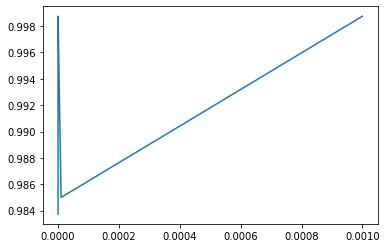

In [24]:
import numpy as np
import matplotlib.pyplot as plt
a = np.array(all_purs)
x = np.array(test_param)
plt.plot(x,a[24::25,1])

In [25]:
a[24::25,1]

array([0.99875, 0.985  , 0.99875, 0.99875, 0.98375])